In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import warnings, cv2
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
train_dir = "../input/yawn-eye-dataset-new/dataset_new/train/"
test_dir = "../input/yawn-eye-dataset-new/dataset_new/test/"

In [5]:
def load_images(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels

In [6]:
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/617 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

In [7]:
X_train = X_train / 255.
X_test = X_test / 255.

In [8]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
cnn = Sequential()

cnn.add(Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(224,224,3)))
cnn.add(MaxPooling2D(pool_size=2))

cnn.add(Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.2))

cnn.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(MaxPooling2D(pool_size=2))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(units=128,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Dense(units=4,activation='softmax'))

2022-08-18 13:17:13.006263: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        1

In [11]:
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [13]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

r = cnn.fit(x=X_train,
            y=y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test,y_test),
            callbacks=[early_stopping,reduce_lr,model_checkpoint])

2022-08-18 13:22:31.157942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
78/78 [==============================] - 37s 451ms/step - loss: 0.5657 - accuracy: 0.7317 - val_loss: 5.8756 - val_accuracy: 0.2517

Epoch 00001: val_accuracy improved from -inf to 0.25173, saving model to checkpoint/
Epoch 2/50
78/78 [==============================] - 35s 451ms/step - loss: 0.3810 - accuracy: 0.8192 - val_loss: 5.8805 - val_accuracy: 0.2517

Epoch 00002: val_accuracy did not improve from 0.25173
Epoch 3/50
78/78 [==============================] - 35s 447ms/step - loss: 0.3524 - accuracy: 0.8435 - val_loss: 4.7510 - val_accuracy: 0.4111

Epoch 00003: val_accuracy improved from 0.25173 to 0.41109, saving model to checkpoint/
Epoch 4/50
78/78 [==============================] - 35s 444ms/step - loss: 0.2691 - accuracy: 0.8829 - val_loss: 2.7278 - val_accuracy: 0.3533

Epoch 00004: val_accuracy did not improve from 0.41109
Epoch 5/50
78/78 [==============================] - 35s 444ms/step - loss: 0.2072 - accuracy: 0.9157 - val_loss: 1.1574 - val_accuracy: 0.517

In [18]:
cnn.load_weights(checkpoint_filename)

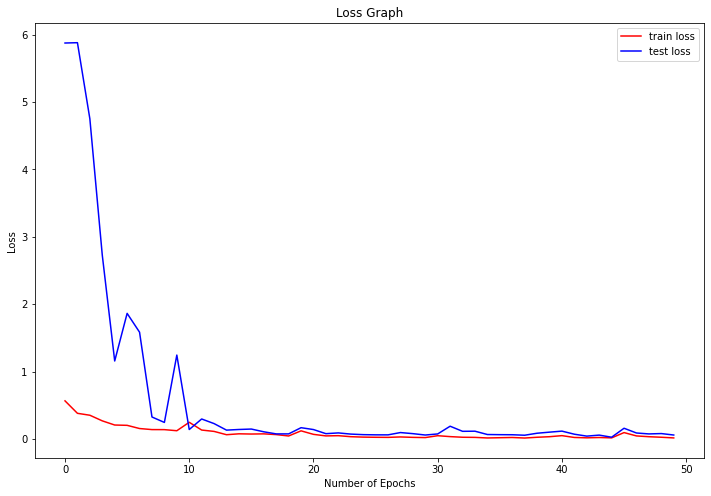

In [19]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

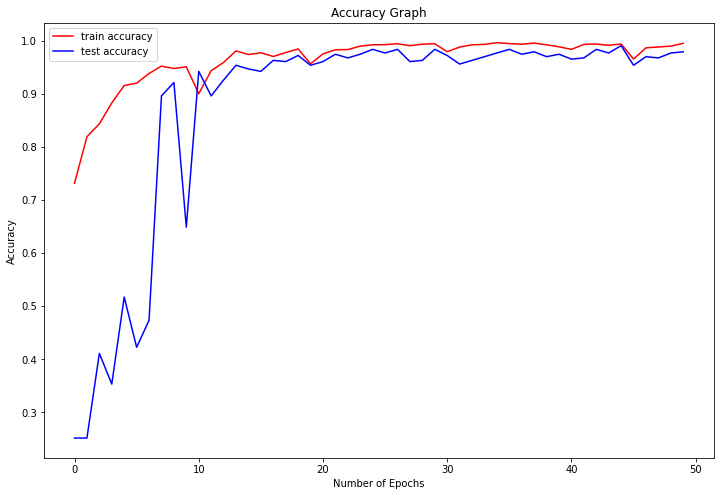

In [20]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [24]:
cnn.save(filepath='drowsiness_detector.model',save_format='h5')
model = load_model(filepath='drowsiness_detector.model')
model